# Загрузка данных и библиотек

In [18]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2955 sha256=e5472c8d50466ead3bdb116841c082d3c11d73141e8b21b2f777f653fad9a111
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [19]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
import tempfile

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler

from tensorflow import keras, feature_column
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
# Последовательная модель НС
from tensorflow.keras.models import Sequential  
# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# Утилиты для to_categorical()
from tensorflow.keras import utils   
# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta   
# Связь с google-диском
from google.colab import files   
# Предварительная обработка данных
from sklearn import preprocessing                 

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

file_path = 'chd_addmit_300.xlsx'
dataframe = pd.read_excel(file_path).drop(['birth','admittion',	'discharge', 'Дата опер.'], axis=1)

# этот признак работает криво. исправлю здесь
#dataframe['sex'] = dataframe['sex'].apply(lambda x: 1 if x=='f' else 0)
#dataframe = dataframe.drop('sex', axis=1)

# Входной пайплайн df_to_dataset. Подготовка датасета. Предобработка. Сплит на выборки

Первый шаг заключается в преобразовании датафреймов Pandas в наборы данных TensorFlow:

In [22]:
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')

# Разделяем на выборки

# вариант разделения по туториалам. пусть будет пока
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

X_train, X_test, y_train, y_test = train_test_split(dataframe, dataframe['target'], 
                                                      test_size=0.2, 
                                                      random_state=5,
                                                      stratify=dataframe['target'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.2, 
                                                      random_state=5,
                                                      stratify=y_train)

# RandomOverSampler. Балансируем классы!
X_train, y_train = RandomOverSampler(sampling_strategy='minority').fit_resample(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
y_train = y_train.reset_index(drop=True)

# Преобразуем датафрейм Pandas в наборы данных TensorFlow
batch_size = 256
train_ds = df_to_dataset(X_train, batch_size=batch_size)
val_ds = df_to_dataset(X_val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(X_test, shuffle=False, batch_size=batch_size)

<ipython-input-22-d4fe6dc2732e>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-22-d4fe6dc2732e>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Здесь стоит обратить внимание на то, что наборы данных TensorFlow и результаты дальнейших преобразований данных не хранятся в памяти так же, как хранятся датафреймы Pandas. Они, по сути, представляют собой конвейер. Через него, пакет за пакетом, походят данные, что позволяет модели эффективно обучаться на наборах данных, которые слишком велики для размещения их в памяти. Именно поэтому мы преобразуем в наборы данных словари датафреймов, а не реальные данные. Обратите внимание на то, что мы, кроме прочего, задаём сейчас, а не во время обучения модели, размер пакета данных, поступая не так, как обычно поступают при использовании API Keras.

## Нормализация входных/выходных данных

In [23]:
# предобработка слоя с числовыми призанками
def get_normalization_layer(name, dataset):
  # Создаем слой нормализации для объекта.
  normalizer = layers.Normalization(axis=None)
  # Подготовка набора данных, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Обучить статистику данных.
  normalizer.adapt(feature_ds)
  return normalizer

# предобработка слоя с категориальными призанками
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Создайтся слой, который превращает строки в целые индексы.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # В противном случае создайтся слой, который превращает целые значения в целые индексы.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)
  # Подготовка `tf.data.Dataset`, который дает только этот признак.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Изучить набор возможных значений и присвоить им фиксированный целочисленный индекс.
  index.adapt(feature_ds)
  # Кодировать целочисленные индексы.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
  # Применить многократное горячее кодирование к индексам. Лямбда-функция захватывает слои,
  # чтобы вы могли использовать их или позже включить в функциональную модель Keras.
  return lambda feature: encoder(index(feature))

all_inputs = [] # inputs
encoded_features = [] # output

# Numerical features.
for header in dataframe.columns.tolist():
  if dataframe[header].dtypes in ['float64', 'int64']:
    # inputs
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    # output
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    # append
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Сategorical features.
categorical_cols = dataframe.loc[:,dataframe.dtypes == 'object'].columns.tolist()
for header in categorical_cols:
    # inputs
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # output
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    # append
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)


In [24]:
# inputs
display(all_inputs)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'height')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'weight')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BMI')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BSA')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'target')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Операции (все в ИБ)')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Перенесенные опер. (из Анамн.)')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Диагноз')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'МКБ')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Соп. забол. (из Анамн.)')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Медикам. леч. по поводу осн. забол. (из Анамн.)')>,
 <KerasTensor: shape=(N

In [25]:
# output
display(encoded_features)

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_9')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_13')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_14')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_15')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_16')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_17')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_18')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (

# Обучение

Здесь главное правильно указать первый слой (наши признаки) и последний (количество классов в таргете). Но тк их всего два то можно указать единицу, что я и сделал. Все остальное завист от уровня знаний и предпочтений. Нужно экспериментировать

In [26]:
%%time

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  all_features = tf.keras.layers.concatenate(encoded_features)        # входной. слой признаков
  x = tf.keras.layers.Dense(2097152, activation='linear')(all_features)  # 2097152     
  x = tf.keras.layers.Dropout(0.1)(x)                                 # боремся с переобучением
  x = tf.keras.layers.BatchNormalization()(x)                         # боремся с переобучением
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)          # выходной слой

  model = tf.keras.Model(all_inputs, output)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

model = make_model()

# сохраним веса
#checkpoint_path = "/content/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1)

history = model.fit(train_ds,
                        validation_data=val_ds,
                        batch_size=50, 
                        epochs=13,
                        validation_split=0.2,
                        #callbacks=[cp_callback],
                        verbose=1)

# сохраним модель
#json_file = 'model.json'
#model_json = model.to_json()
#with open(json_file, 'w') as f:
#  f.write(model_json)


model.evaluate(test_ds, verbose=1)


Epoch 1/13
2/2 [==============================] - ETA: 0s - loss: 1.1238 - tp: 62.0000 - fp: 117.0000 - tn: 66.0000 - fn: 121.0000 - accuracy: 0.3497 - precision: 0.3464 - recall: 0.3388 - auc: 0.4654 - prc: 0.5747  
Epoch 1: saving model to /content/cp.ckpt
2/2 [==============================] - 93s 28s/step - loss: 1.1238 - tp: 62.0000 - fp: 117.0000 - tn: 66.0000 - fn: 121.0000 - accuracy: 0.3497 - precision: 0.3464 - recall: 0.3388 - auc: 0.4654 - prc: 0.5747 - val_loss: 0.1587 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 46.0000 - val_fn: 2.0000 - val_accuracy: 0.9583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7935 - val_prc: 0.0913
Epoch 2/13
2/2 [==============================] - ETA: 0s - loss: 0.6494 - tp: 166.0000 - fp: 2.0000 - tn: 181.0000 - fn: 17.0000 - accuracy: 0.9481 - precision: 0.9881 - recall: 0.9071 - auc: 0.9468 - prc: 0.9580 
Epoch 2: saving model to /content/cp.ckpt
2/2 [==============================] - 61s 24s/step - loss: 0.6494 

[0.3023858368396759,
 0.0,
 0.0,
 57.0,
 3.0,
 0.949999988079071,
 0.0,
 0.0,
 0.6666666865348816,
 0.4006277322769165]

In [27]:
# загрузить модель
#with open(json_file, 'r') as f:
#  loaded_model = model_from_json(f.read())

# загрузить веса
#model = loaded_model.load_weights(checkpoint_path)

## Сводка по архитектуре

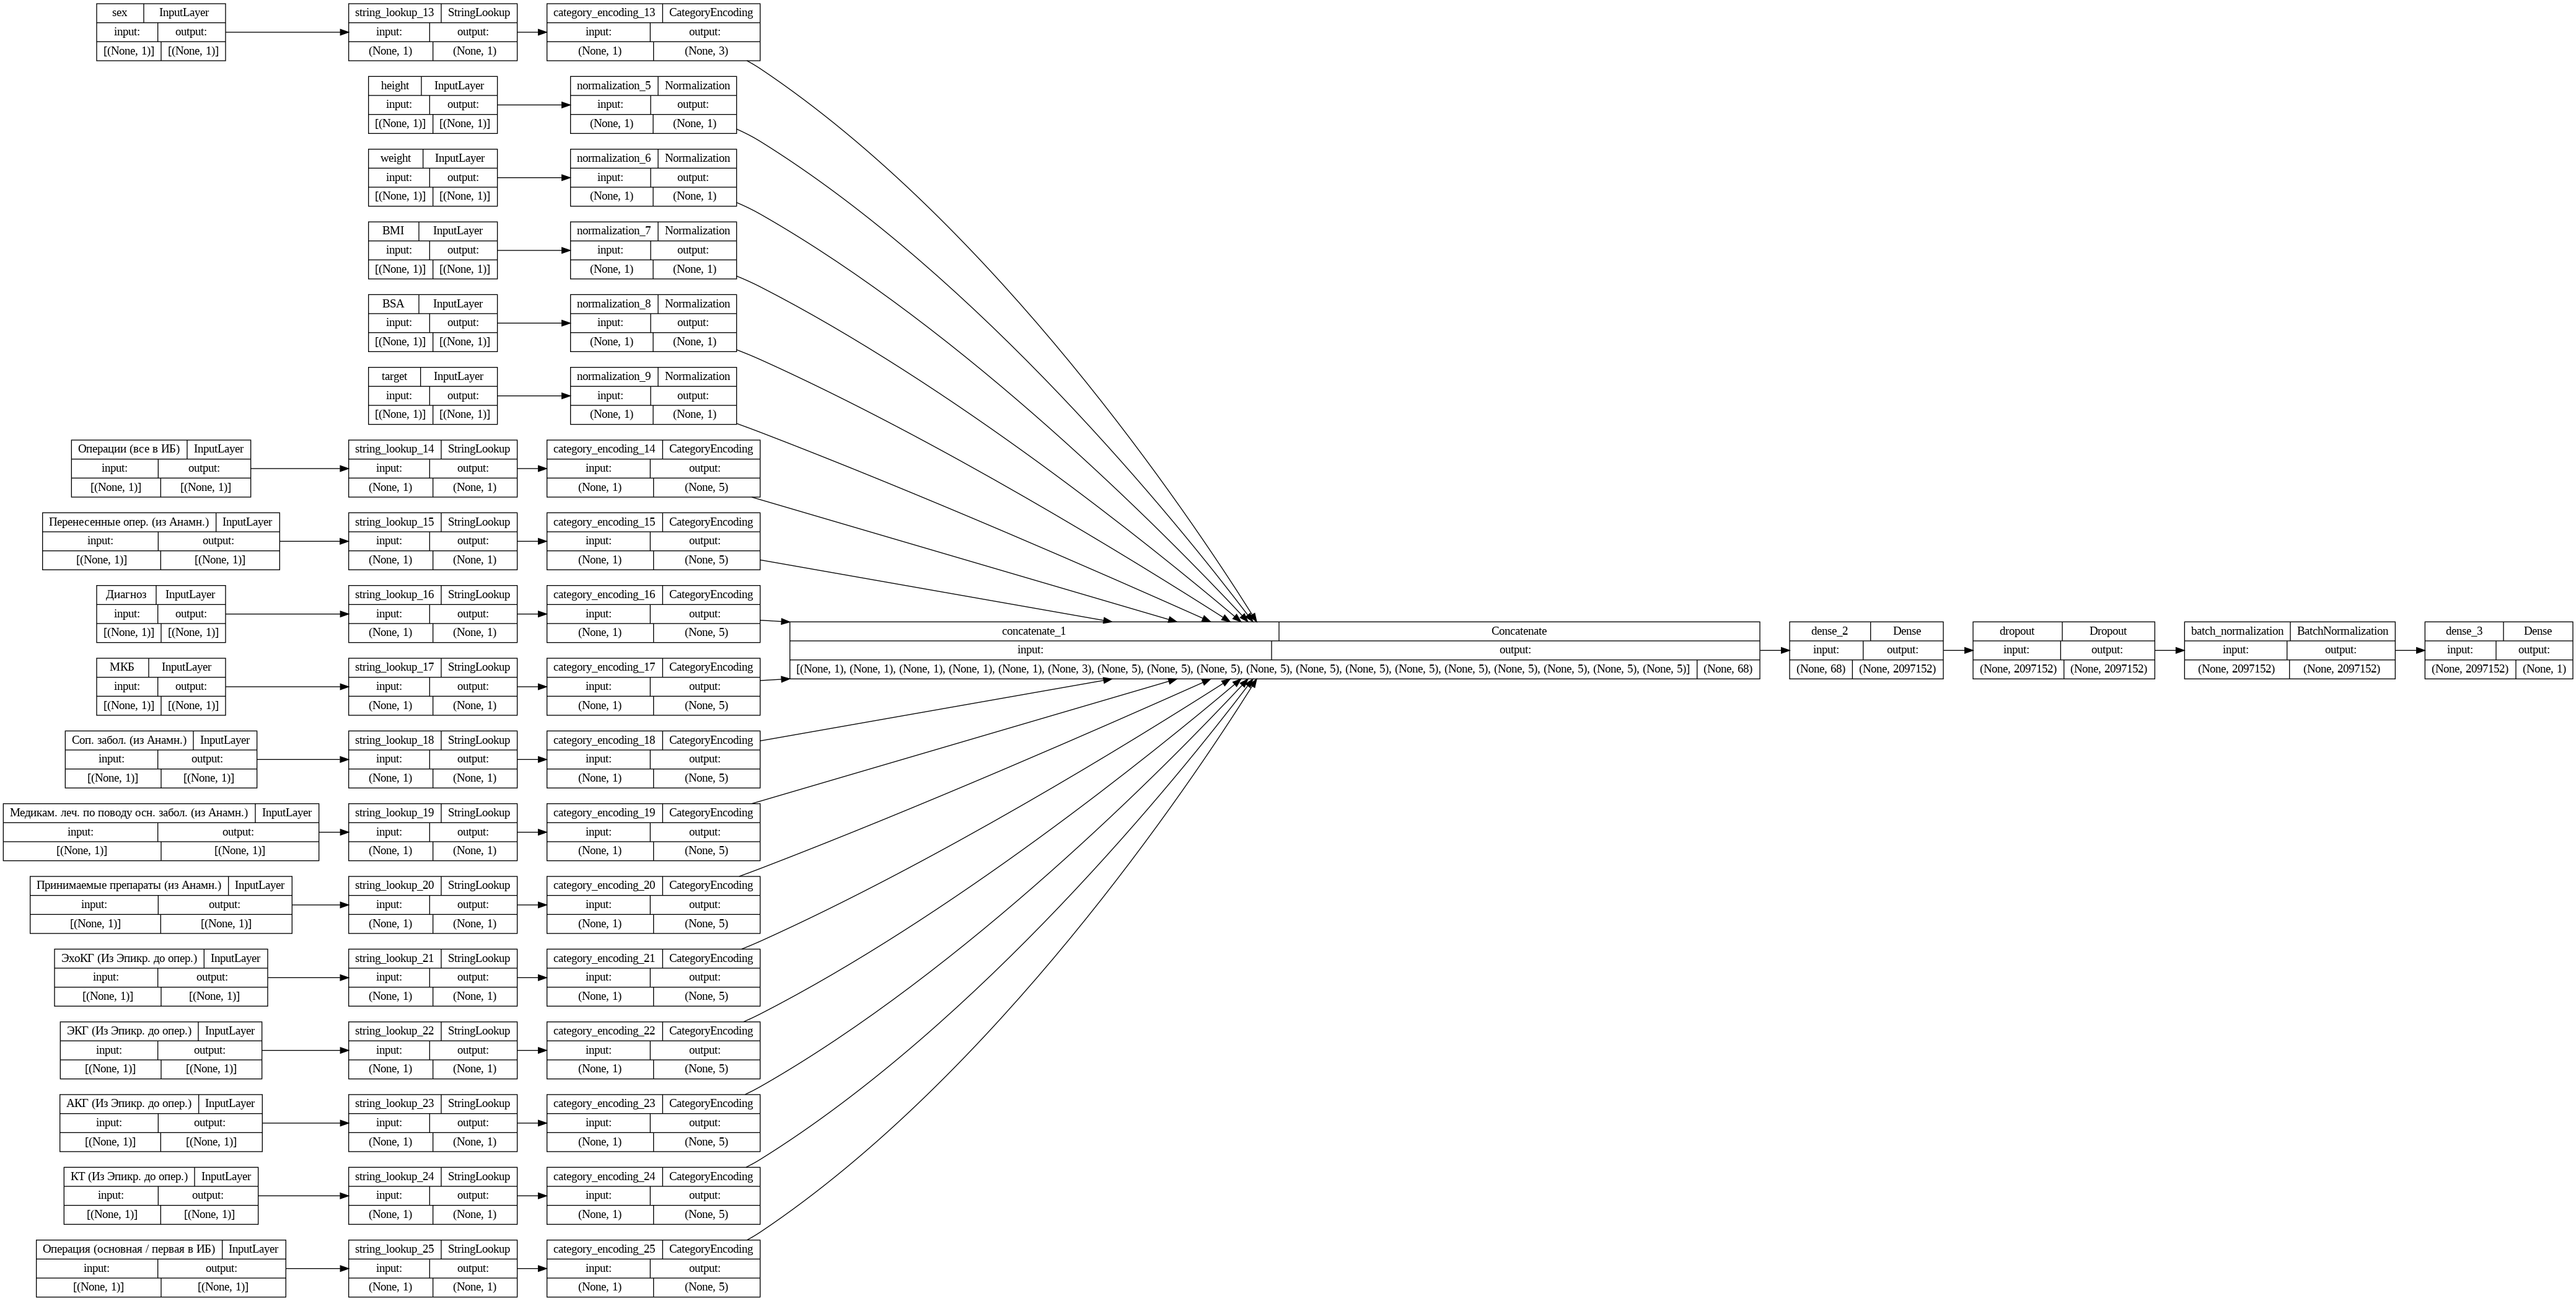

In [28]:
# Схема архитектуры. Пока не работает как нужно. Разбираюсь с этим
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Операции (все в ИБ) (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 Перенесенные опер. (из Анамн.)  [(None, 1)]         0           []                               
  (InputLayer)                                                                                    
                                                                                            

# Тест

1/1 [==============================] - 1s 1s/step


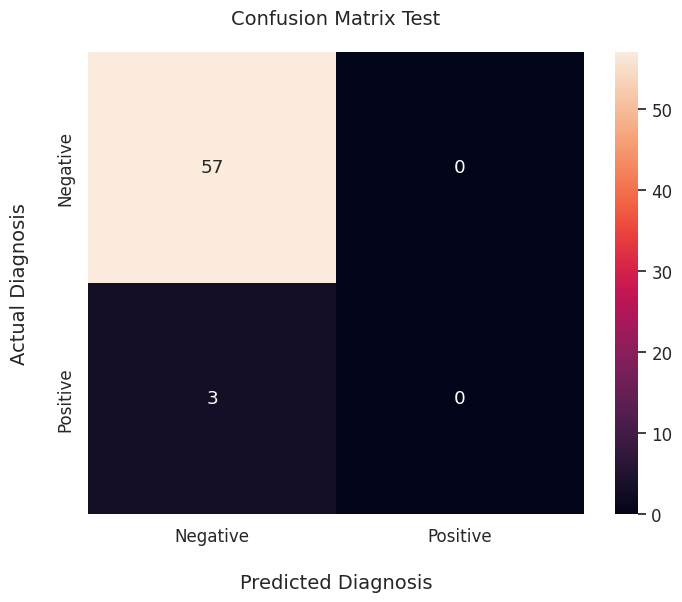

DummyClassifier: 0.95
accuracy_score: 0.95
AUC-ROC: 0.95
f1_score: 0.00
recall_score: 0.00
precision_score: 0.00


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


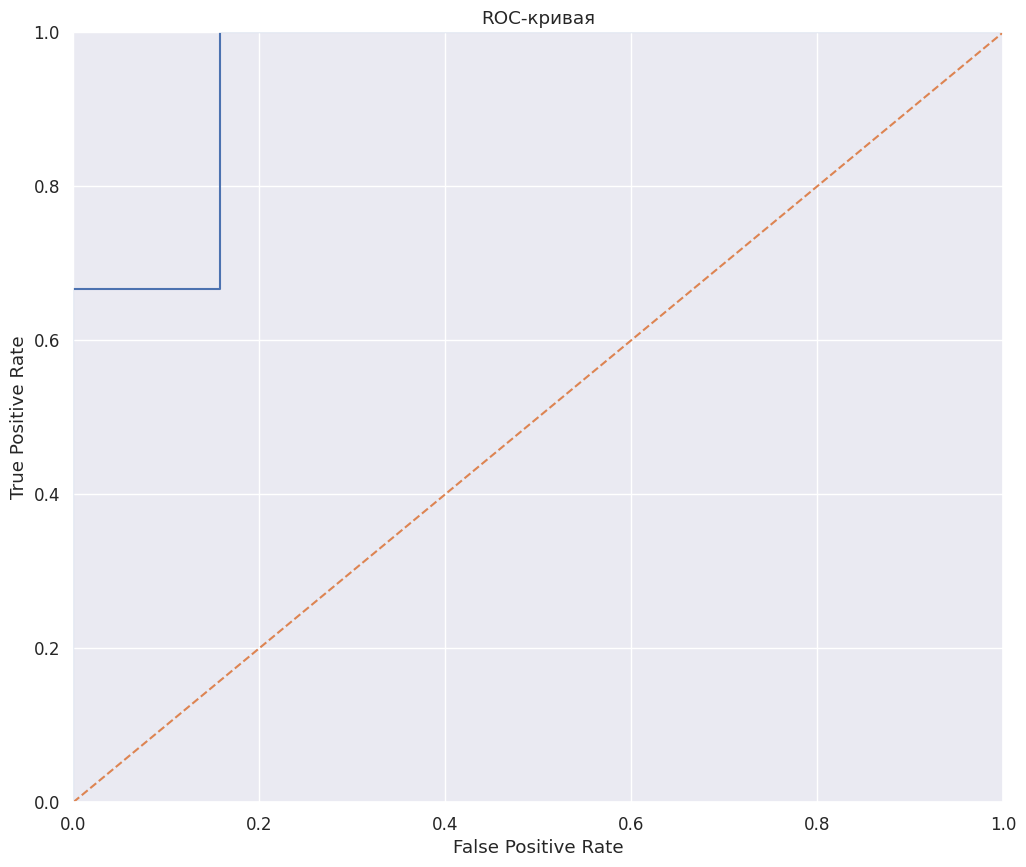

In [31]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title("Confusion Matrix Test", fontsize=14, pad=20)
plt.show()


clf = DummyClassifier(strategy='most_frequent', random_state=5)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print('accuracy_score: %.2f' % accuracy_score(y_test ,[round(value) for value in y_pred]))
print("AUC-ROC: %.2f" % roc_auc_score(y_test, predict_proba_one))
print("f1_score: %.2f" % f1_score(y_test, y_pred))
print("recall_score: %.2f" % recall_score(y_test, y_pred))
print("precision_score: %.2f" % precision_score(y_test, y_pred))

# Roc кривая
fpr, tpr, thresholds = roc_curve(y_test, predict_proba_one)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()